In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
with open('data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# functions

In [5]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y_src = np.zeros([output_window, num_samples, num_feature])
        Y_tgt = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window 
            end_y = start_y + output_window 
            Y_src[:,i] = y[(start_y-1):(end_y-1)]
            Y_tgt[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y_src = Y_src.reshape(Y_src.shape[0], Y_src.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        Y_tgt = Y_tgt.reshape(Y_tgt.shape[0], Y_tgt.shape[1], num_feature).transpose((1,0,2))
        self.x = X[:,:-1,:]
        self.y_src = Y_src
        self.y_tgt = Y_tgt
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y_src[i], self.y_tgt[i]

    def __len__(self):
        return self.len

In [6]:
"""
multihead attention layer 에서 attention energy 값 저장하도록 class 수정
need_weights=True 로 설정
"""

def attn_forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True, attn_mask: Optional[torch.Tensor] = None,
            average_attn_weights: bool = True) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    is_batched = query.dim() == 3
    if self.batch_first and is_batched:
        query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

    if not self._qkv_same_embed_dim:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, use_separate_proj_weight=True,
            q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
            v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights)
    else:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, average_attn_weights=average_attn_weights)
    
    # property 추가
    self.attn = attn_output_weights

    if self.batch_first and is_batched:
        return attn_output.transpose(1, 0), attn_output_weights
    else:
        return attn_output, attn_output_weights

In [7]:
class transformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128): 
        super(transformer, self).__init__() 
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.transformer = nn.Transformer(d_model=self.d_model, 
                                          nhead=self.nhead,
                                          num_encoder_layers=self.num_encoder_layers,
                                          num_decoder_layers=self.num_decoder_layers,
                                          dim_feedforward=self.dim_feedforward,
                                          batch_first=True) 
        # self.linear = nn.Linear(self.d_model, 1)

    def forward(self, src, tgt, tgt_mask=None):
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        # output2 = self.linear(output1)
        return output

In [8]:
# teacher forcing = 0
# decoding 을 max len 만큼 반복해야해서 시간이 훨씬 길어짐

def train(model, train_loader, max_len, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0
    attention_list = []

    for x, y_in, y_out in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()

        y_init = x[:,-1,:].unsqueeze(1)
        y_in = y_init.clone().detach()

        for i in range(max_len):
            output = model(x, y_in).to(device)
            y_in = torch.cat([y_init, output], dim=1) 

        attention_list.append(list(model.transformer.decoder.layers[0].multihead_attn.attn.detach().cpu().numpy()))

        loss = criterion(output, y_out)
        # loss = criterion(output, y_out[:,:,0])
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return output.detach().cpu().numpy(), y_out.detach().cpu().numpy(), np.array(sum(attention_list,[])), train_loss

In [85]:
# teacher forcing = 1
def train(model, train_loader, tgt_mask, optimizer, criterion, gradient_clipping=False, device='cuda'):
    model.train()
    total_loss = 0.0
    attention_list = []

    for x, y_in, y_out in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()
        output = model(x, y_in, tgt_mask=tgt_mask).to(device)
        attention_list.append(list(model.transformer.decoder.layers[0].multihead_attn.attn.detach().cpu().numpy()))

        loss = criterion(output, y_out)
        loss.backward()
        if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return output.detach().cpu().numpy(), y_out.detach().cpu().numpy(), np.array(sum(attention_list,[])), train_loss

In [199]:
# teacher forcing = 0
# decoding 을 max len 만큼 반복해야해서 시간이 훨씬 길어짐

def train(model, train_loader, max_len, optimizer, criterion, gradient_clipping=False, device='cuda'):
    model.train()
    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for x, y_in, y_out in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y_in = y_in.to(device).float()
        y_out = y_out.to(device).float()

        # y_init = x[:,-1,:].unsqueeze(1)
        # y_in = y_init.clone().detach()
        enc_src = model.transformer.encoder(x)

        y_trg = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)

        # for i in range(max_len):
        #     output = model(x, y_in).to(device)
        #     y_in = torch.cat([y_init, output], dim=1) 

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(y_trg.shape[1]).to(device)
            output = model.transformer.decoder(y_trg, enc_src, target_mask)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            y_trg = torch.cat([y_trg, output[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)

        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(y_trg[:,1:,:].detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))

        loss = criterion(y_trg[:,1:,:], y_out)
        # loss = criterion(output, y_out[:,:,0])
        loss.backward()
        if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list,[])), train_loss

In [187]:
def predict(model, test_loader, max_len, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for t, (x, y_in, y_out) in enumerate(test_loader):
        x = x.to(device).float()
        y_out = y_out.to(device).float()

        with torch.no_grad():
            enc_src = model.transformer.encoder(x)

        y_trg = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(y_trg.shape[1]).to(device)

            with torch.no_grad():
                output = model.transformer.decoder(y_trg, enc_src, target_mask)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            y_trg = torch.cat([y_trg, output[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)
            # print(y_trg.shape)
            # print(attention.shape)

        # print(y_trg[:,1:,:].shape)
        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(y_trg[:,1:,:].detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(y_trg[:,1:,:], y_out)
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list, [])), test_loss

# scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [15]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [16]:
pv = pv.set_index('datetime')

In [17]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [18]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv_train[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=16)

In [19]:
len(train_loader)

6

In [20]:
len(test_loader)

1

# transformer

- 시계열 데이터 transformer 적용이 목표이기 때문에 최대한 간단한 구조로 적용

- positional embedding 적용 x

- encoder, decoder 모두 1개의 layer

- target seq의 경우 teacher force prop 1/0 두가지로 적용

In [21]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 144 kB 64.1 MB/s 
     |████████████████████████████████| 181 kB 67.0 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b9d6ab748d0118ee2e8d1a7021d8de74c8fa5919c09bddbfa9dcc81f4256b1f2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [22]:
import wandb

In [238]:
wandb.init(name='teacher_forcing=0&gradient_clipping=0.5&epochs=1000', project="transformer", entity="yyyyyjkim")

In [239]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "d_model": 5,
    "nhead": 5,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dim_feedforward": 128
}

In [240]:
device='cuda'
model = transformer(d_model=wandb.config["d_model"], 
                       nhead=wandb.config["nhead"], 
                       num_encoder_layers=wandb.config["num_encoder_layers"], 
                       num_decoder_layers=wandb.config["num_decoder_layers"], 
                       dim_feedforward=wandb.config["dim_feedforward"]).to(device)

optimizer = optim.Adam(model.parameters(), lr = wandb.config['learning_rate'])
criterion = nn.MSELoss()

In [241]:
# multihead attention layer 에서 수정
model.transformer.decoder.layers[0].multihead_attn.__class__._forward = attn_forward
for layer in model.transformer.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [242]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,256 trainable parameters


In [243]:
# 파라미터 초기화
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

transformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonD

In [244]:
target_mask = model.transformer.generate_square_subsequent_mask(24).to(device)

In [245]:
wandb.watch(model, log='all', log_freq=10)

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    # *result_train, train_loss = train(model, train_loader, target_mask, optimizer, criterion, gradient_clipping=None, device='cuda')
    *result_train, train_loss = train(model, train_loader, 24, optimizer, criterion, gradient_clipping=0.5, device='cuda')
    *result_test, test_loss = predict(model, test_loader, 24, criterion, device='cuda')
    
    wandb.log({"train_loss": train_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [246]:
wandb.finish()

test_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.02177
train_loss,0.01716


In [247]:
attention_train = result_train[2]

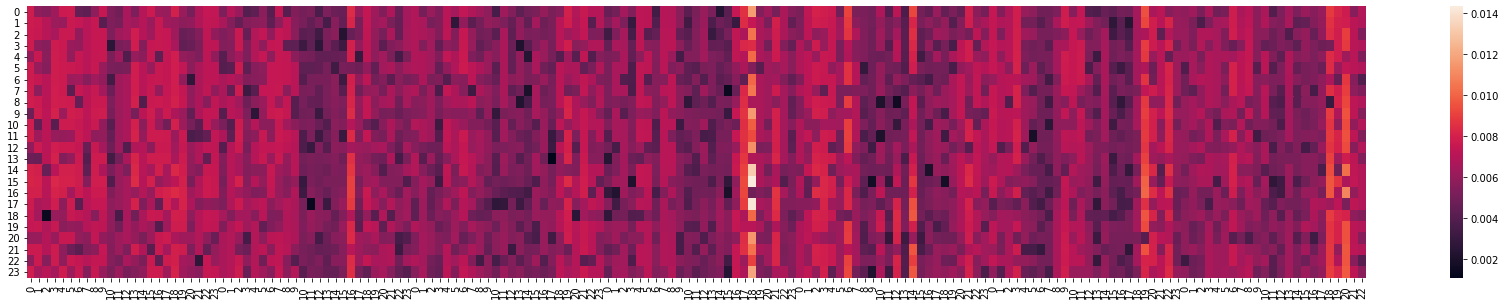

In [249]:
plt.figure(figsize=(30,5))
sns.heatmap(attention_train[0], xticklabels=[i%24 for i in range(167)])
plt.show()

# predict

In [250]:
pred = result_test[0]
true = result_test[1]
attention = result_test[2]

pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [251]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


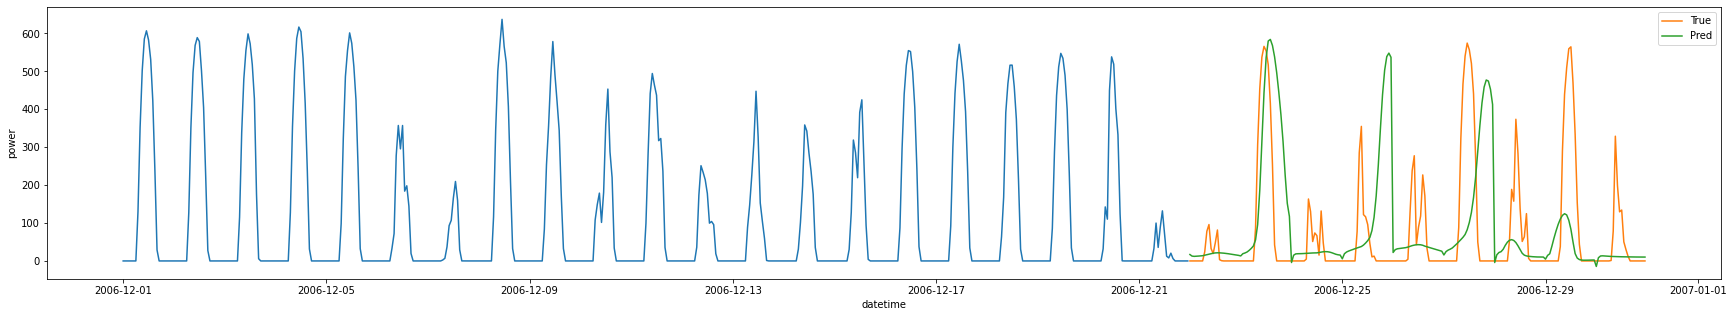

In [141]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


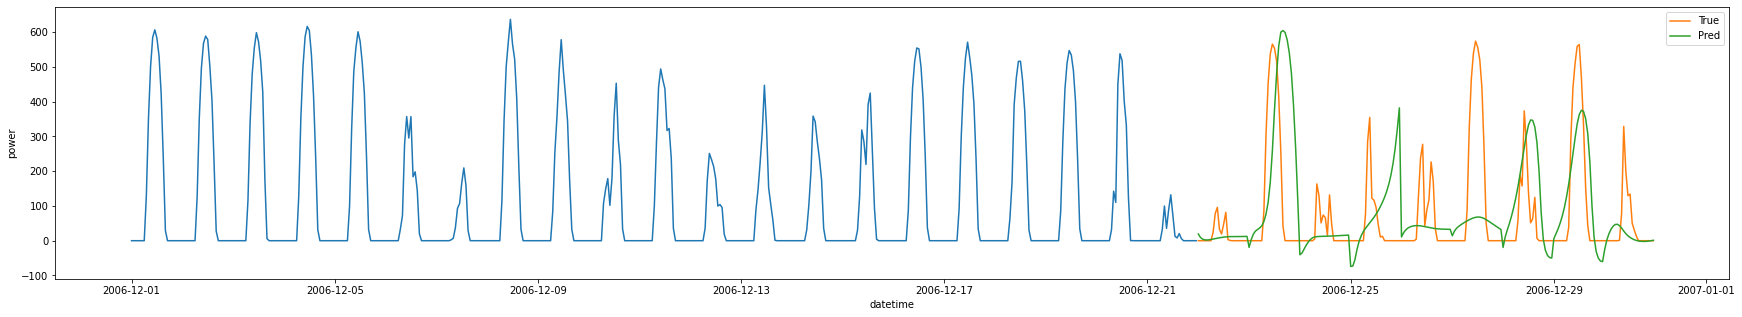

In [155]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


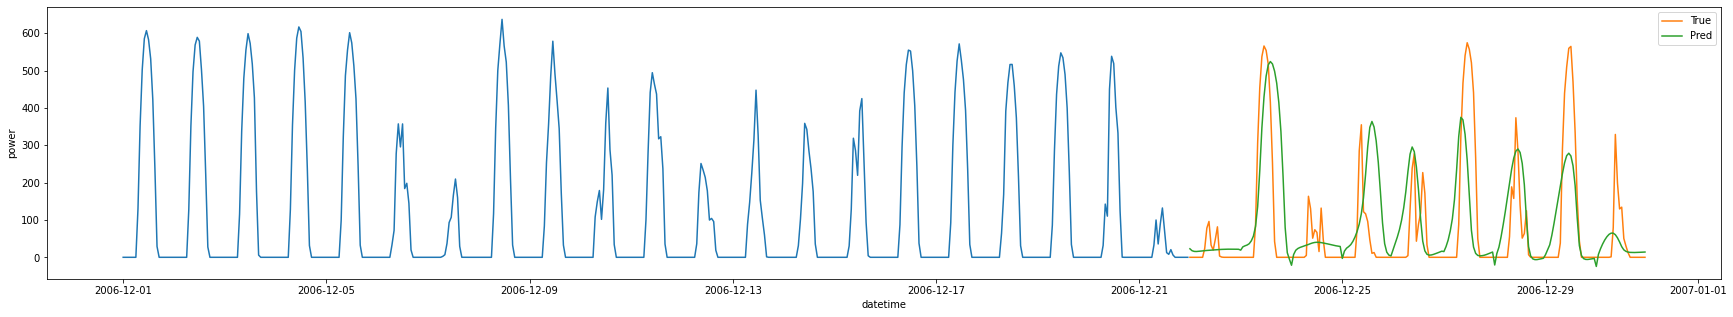

In [170]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


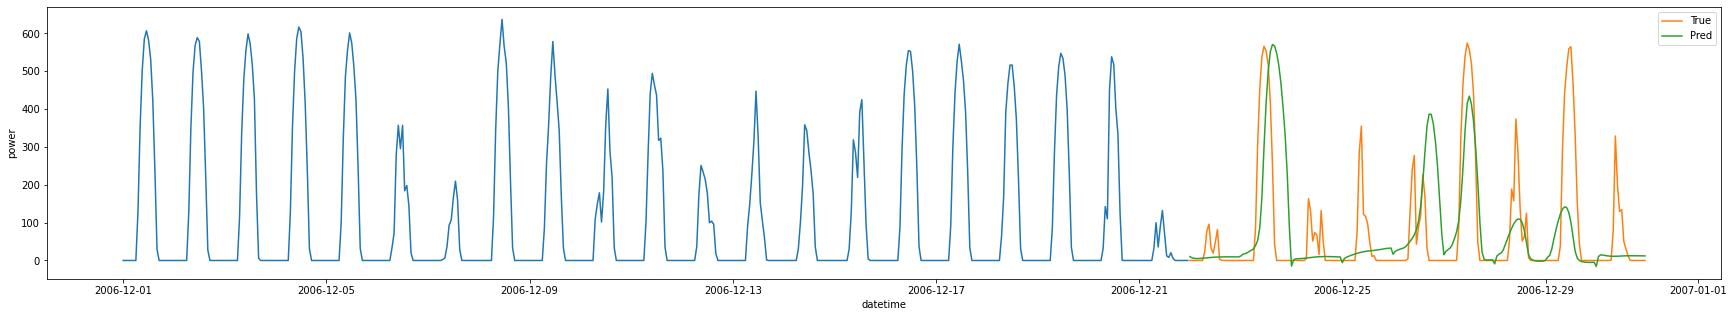

In [184]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


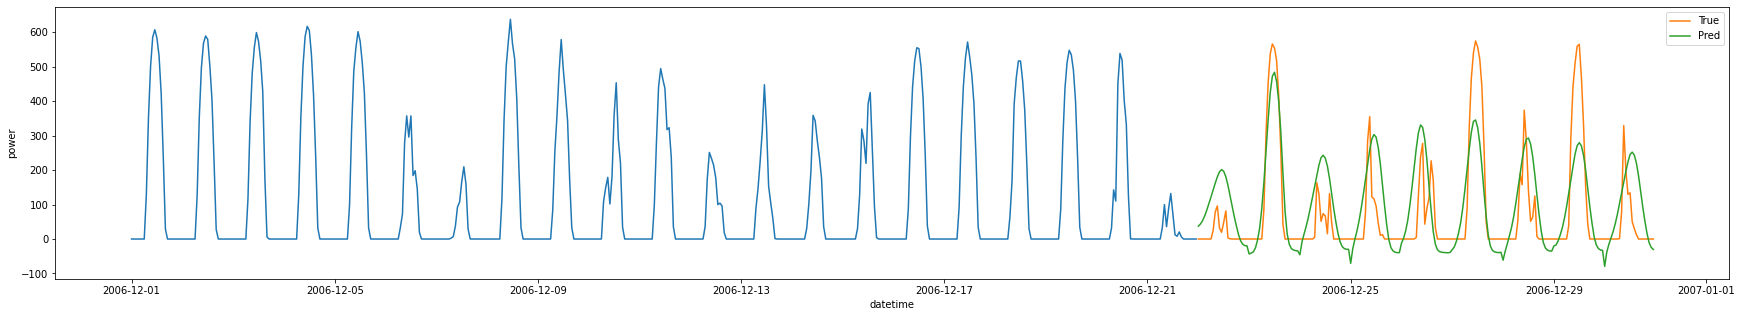

In [206]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


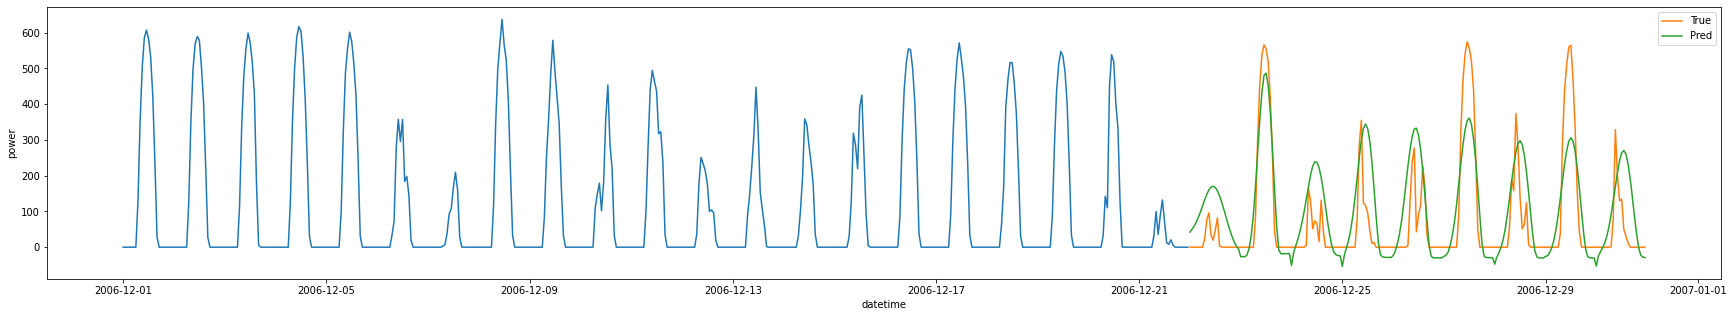

In [221]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


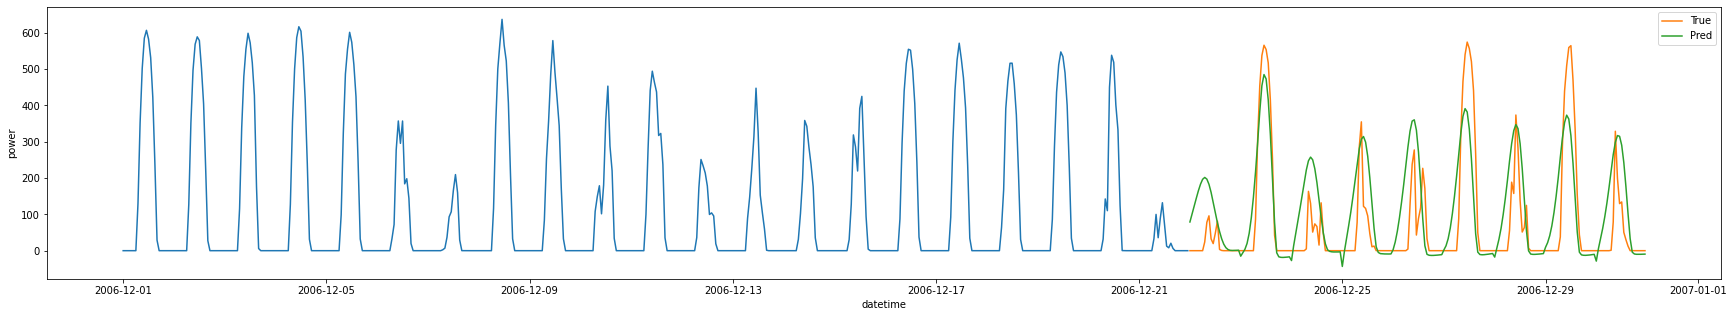

In [236]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


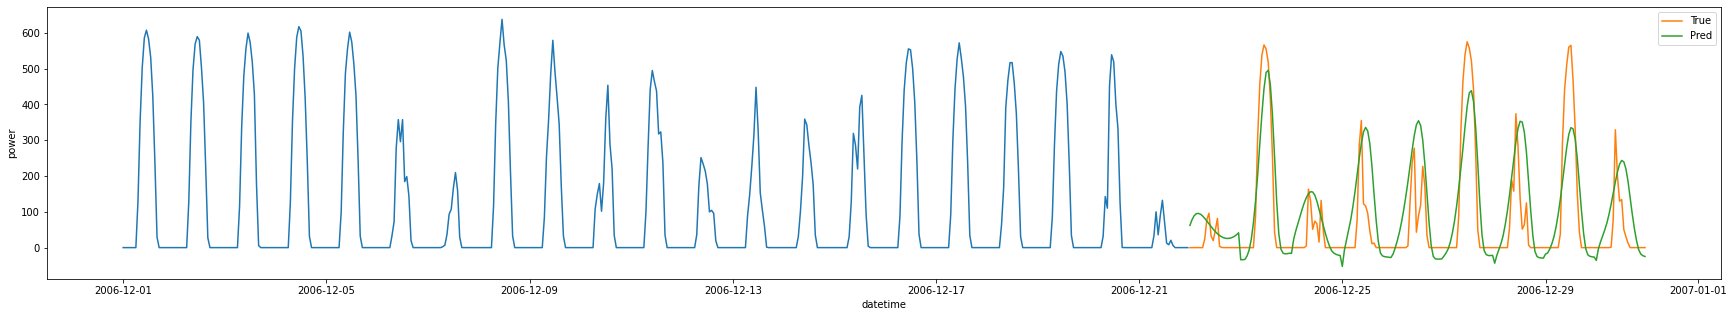

In [252]:
# basic
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

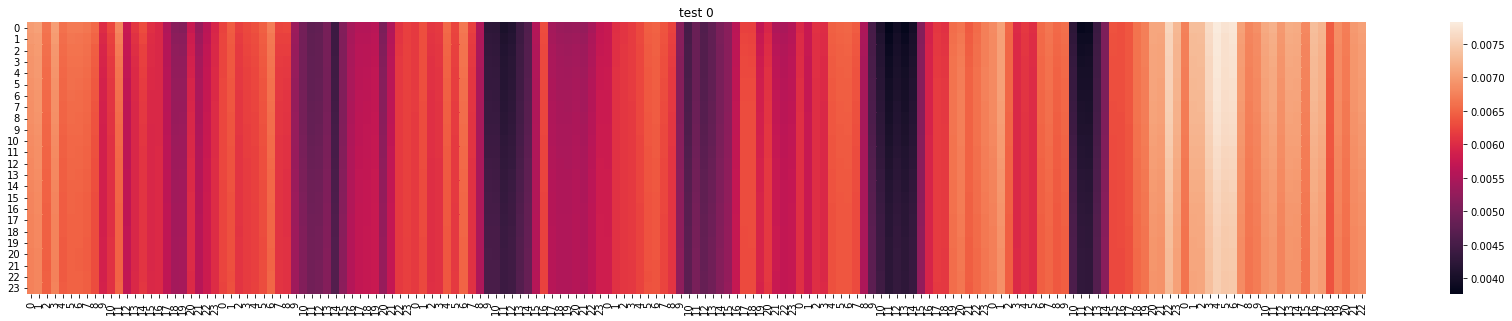

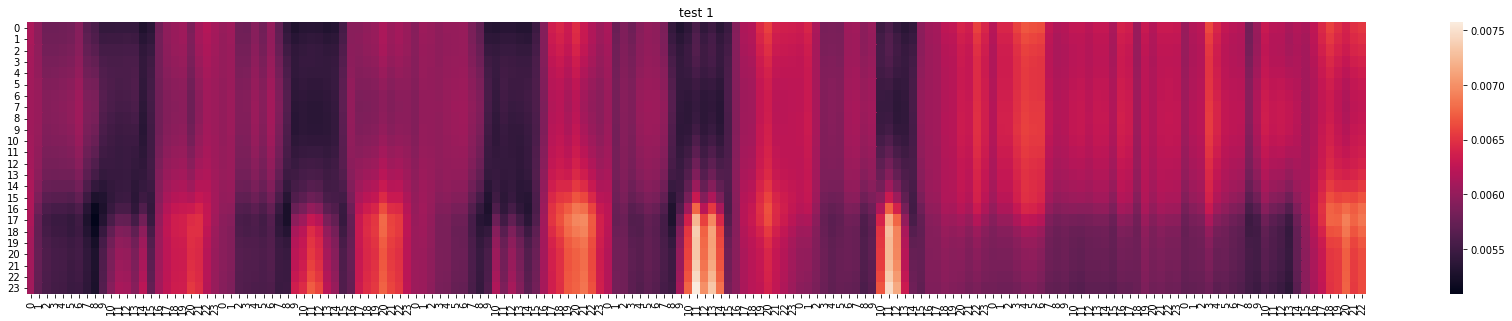

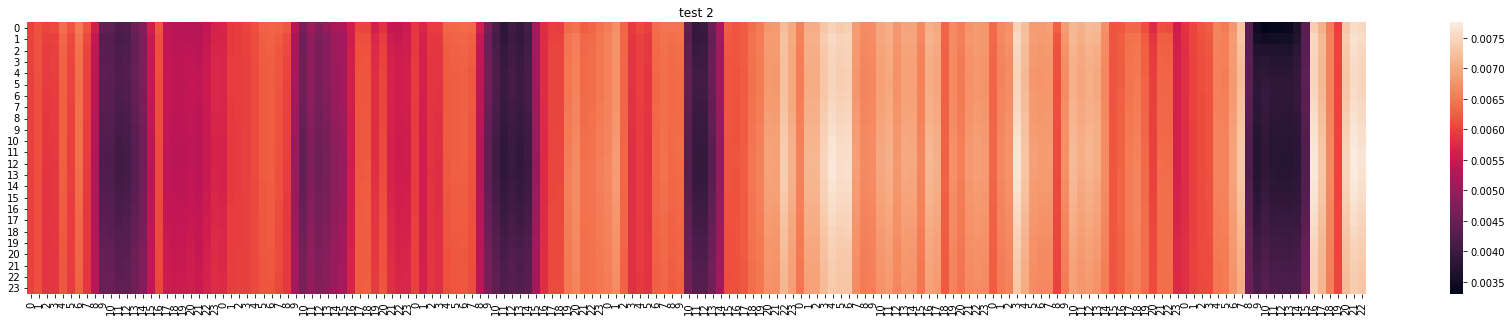

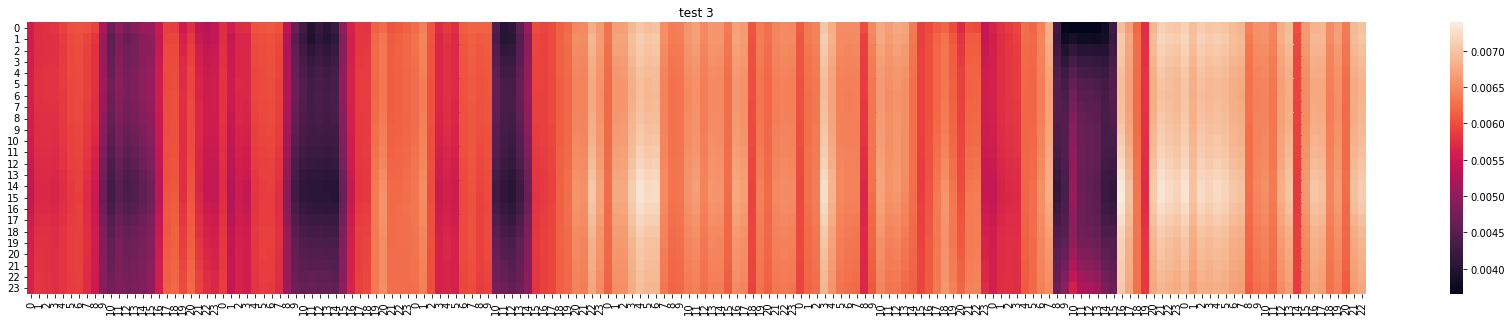

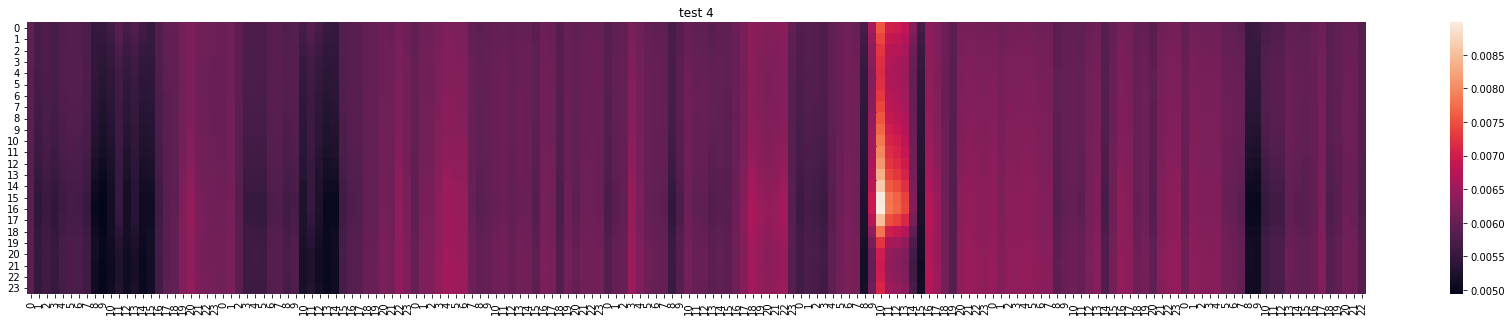

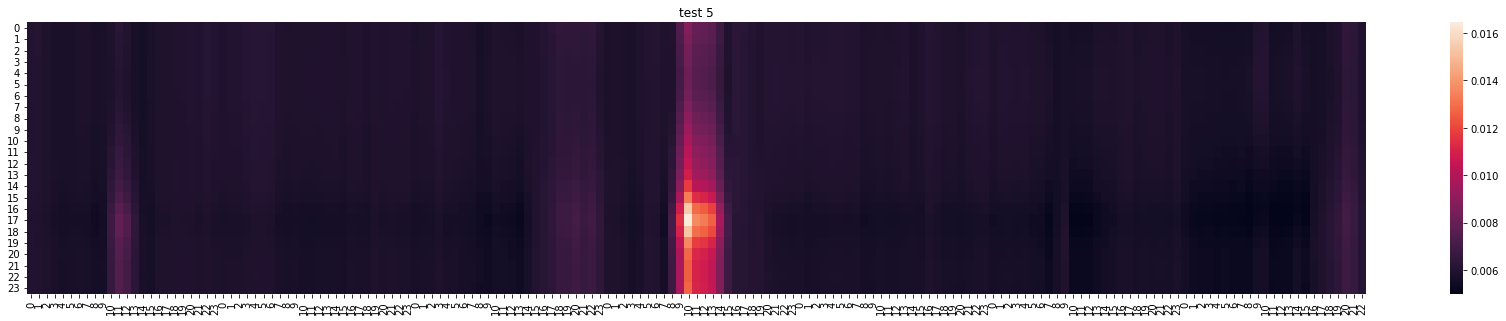

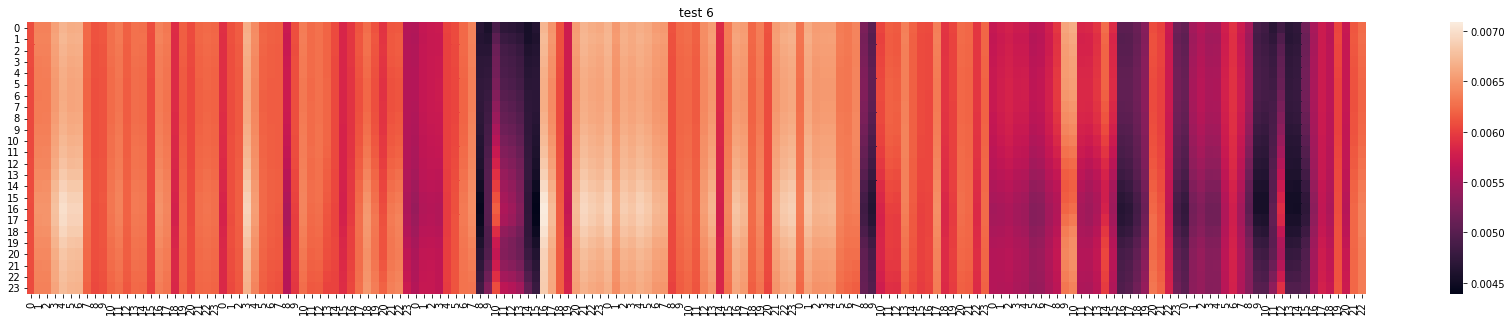

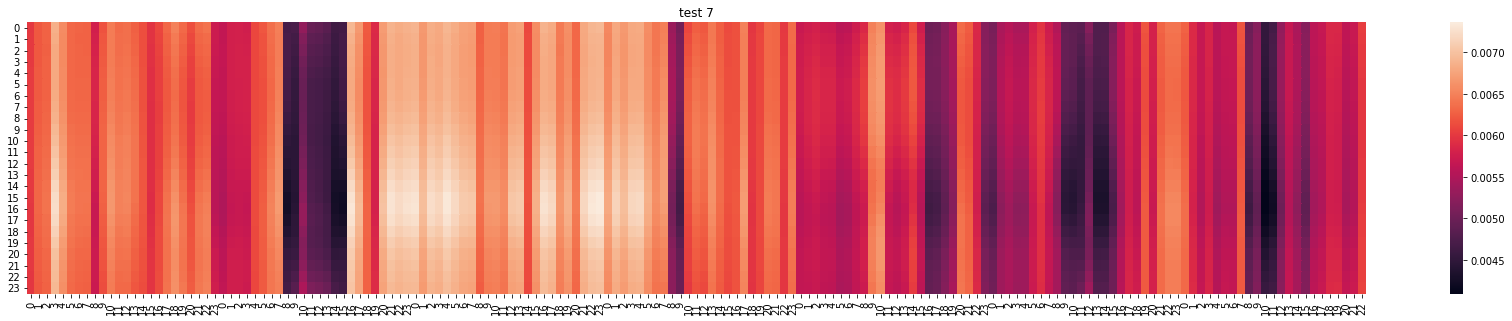

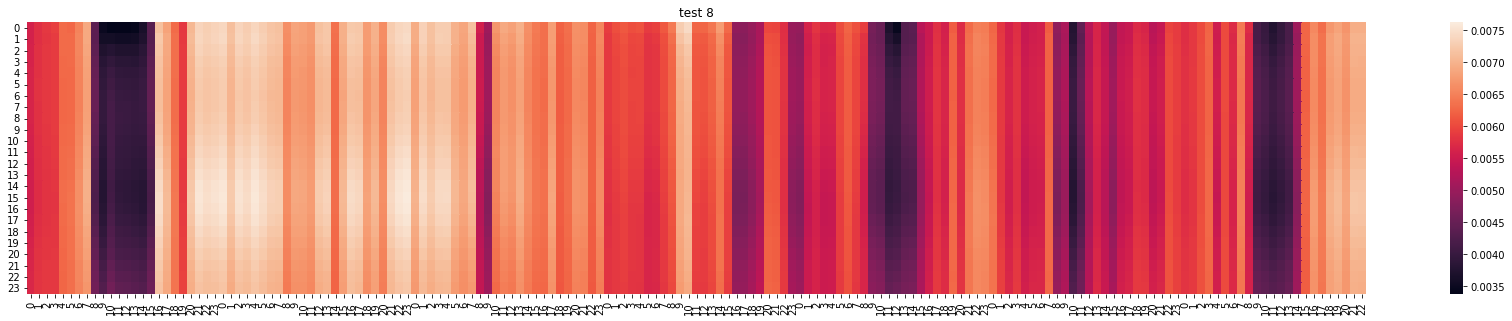

In [253]:
# 2006.12.22 이후 태양열 발전량 예측에 대한 attention energy 시각화
for i, att in enumerate(attention):
    plt.figure(figsize=(30,5))
    sns.heatmap(att, xticklabels=[i%24 for i in range(167)])
    plt.title(f"test {i}")
    plt.show()

# model

# teacher forcing 0

In [ ]:
device='cuda'
# model = nn.Transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, batch_first=True).to(device)
model = transformer(d_model=5, nhead=5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128).to(device)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
# multihead attention layer 에서 수정
model.transformer.decoder.layers[0].multihead_attn.__class__._forward = attn_forward
for layer in model.transformer.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [ ]:
attention_train = train(train_loader, model, max_len=24, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
attention_train.shape

(348, 24, 167)

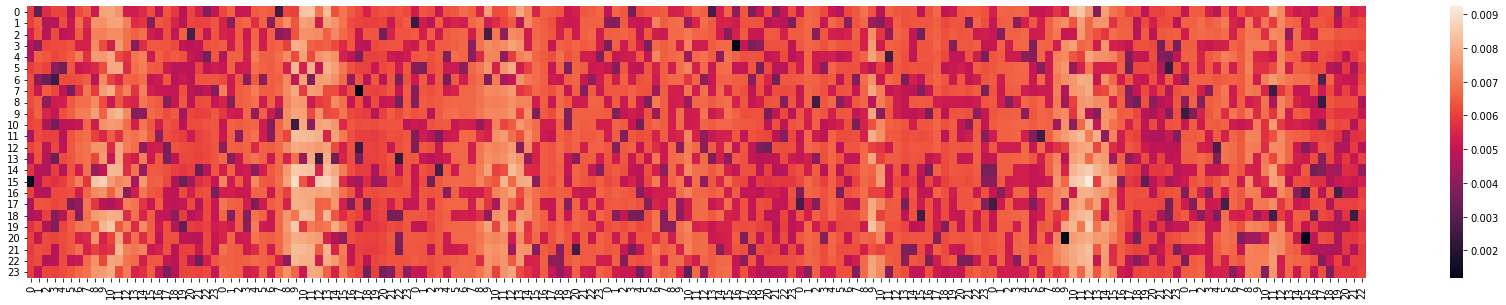

In [ ]:
plt.figure(figsize=(30,5))
sns.heatmap(attention_train[5], xticklabels=[i%24 for i in range(167)])
plt.show()

# predict

In [ ]:
def predict(test_loader, max_len, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for t, (x, y_in, y_out) in enumerate(test_loader):
        x = x.to(device).float()
        y_out = y_out.to(device).float()

        with torch.no_grad():
            enc_src = model.transformer.encoder(x)

        y_trg = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(y_trg.shape[1]).to(device)

            with torch.no_grad():
                output = model.transformer.decoder(y_trg, enc_src, target_mask)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            y_trg = torch.cat([y_trg, output[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)
            # print(y_trg.shape)
            # print(attention.shape)

        # print(y_trg[:,1:,:].shape)
        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(y_trg[:,1:,:].detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))
        loss = criterion(output, y_out)
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list, []))

In [ ]:
x, y_in, y_out = next(iter(test_loader))

In [ ]:
with torch.no_grad():
    x = x.to(device).float()
    enc_src = model.transformer.encoder(x)

In [ ]:
y_trg = x[:,-1,:].unsqueeze(1)
attention = torch.Tensor().to(device)

In [ ]:
max_len = 24

In [ ]:
for _ in range(max_len):
    target_mask = model.transformer.generate_square_subsequent_mask(y_trg.shape[1]).to(device)

    with torch.no_grad():
        output = model.transformer.decoder(y_trg, enc_src, target_mask)
    attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

    y_trg = torch.cat([y_trg, output[:,-1,:].unsqueeze(1)], dim=1)
    attention = torch.cat([attention, attn_], dim=1)
    print(y_trg.shape)
    print(attention.shape)

In [ ]:
pred, true, attention_test = predict(test_loader, max_len=24)

torch.Size([4, 24, 5])
torch.Size([4, 24, 5])
torch.Size([1, 24, 5])
test loss: 0.88232


In [ ]:
pred[0].shape

(24, 5)

In [ ]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [ ]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


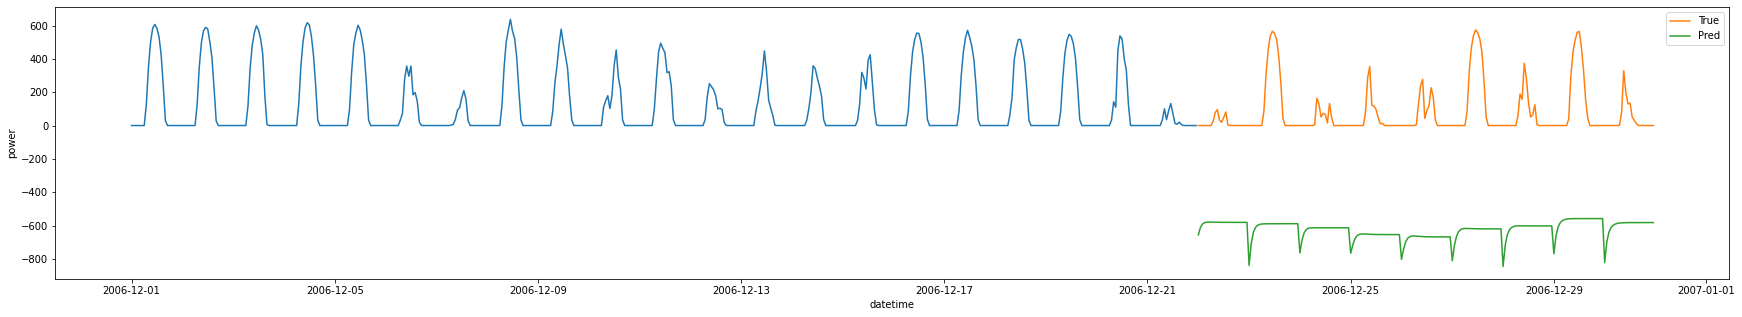

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

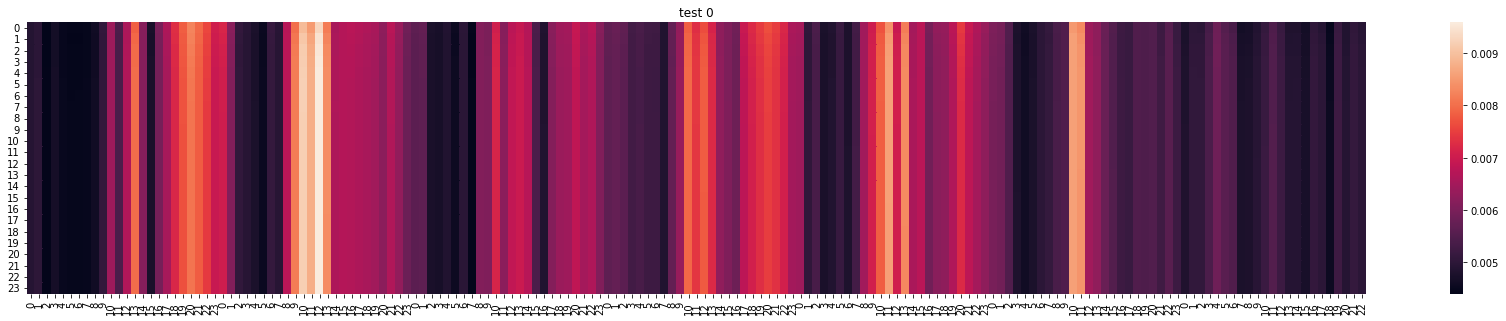

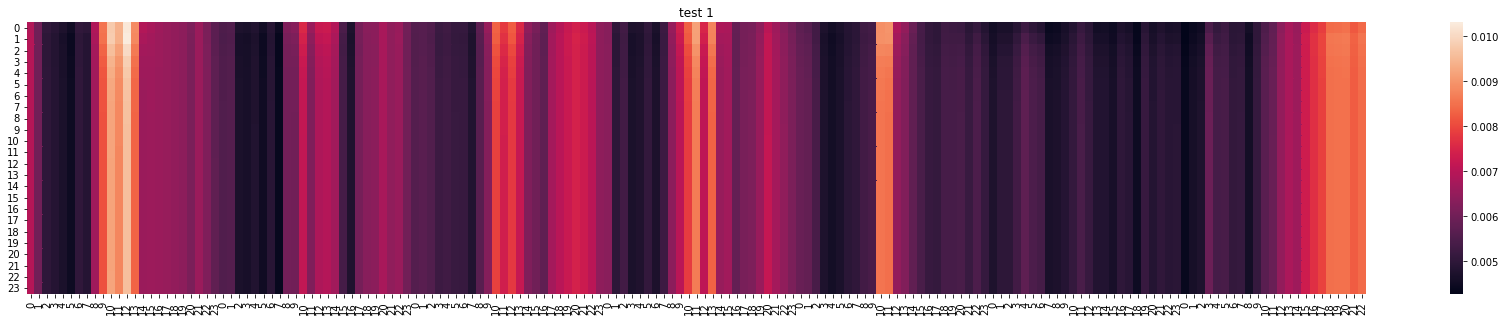

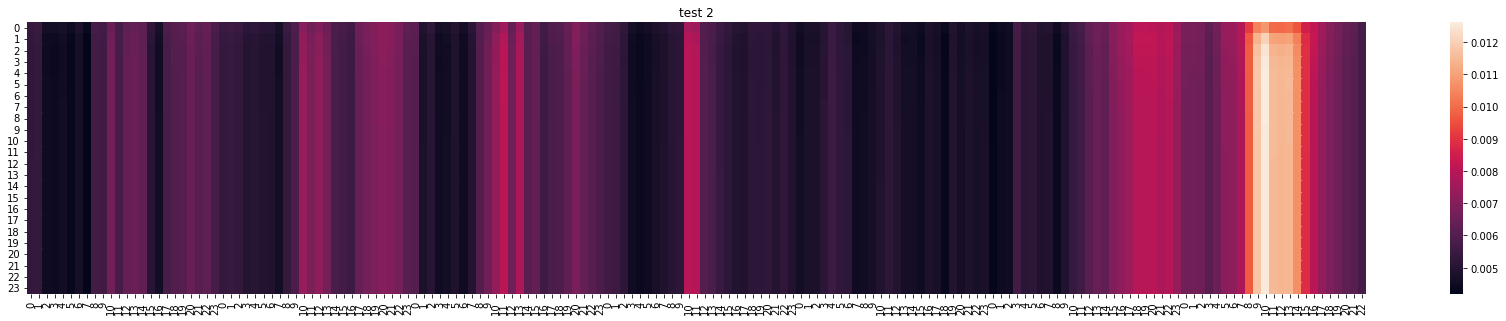

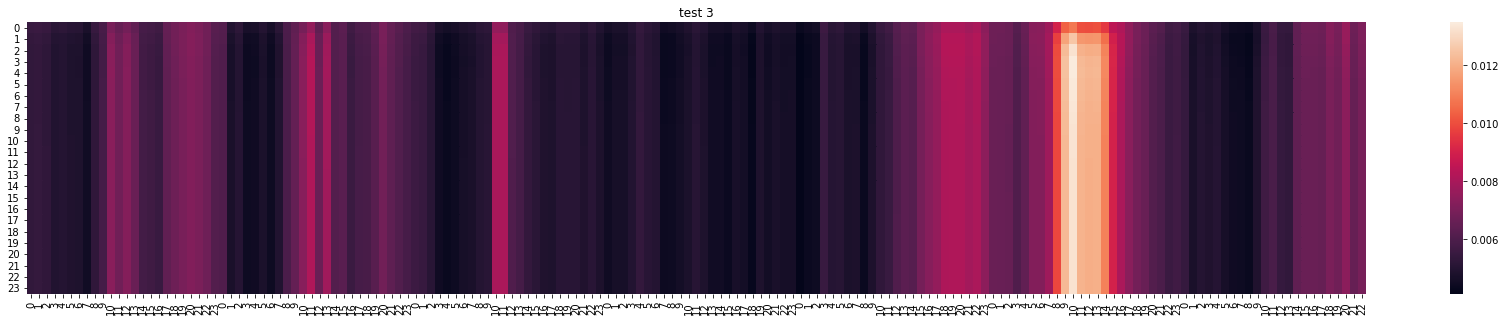

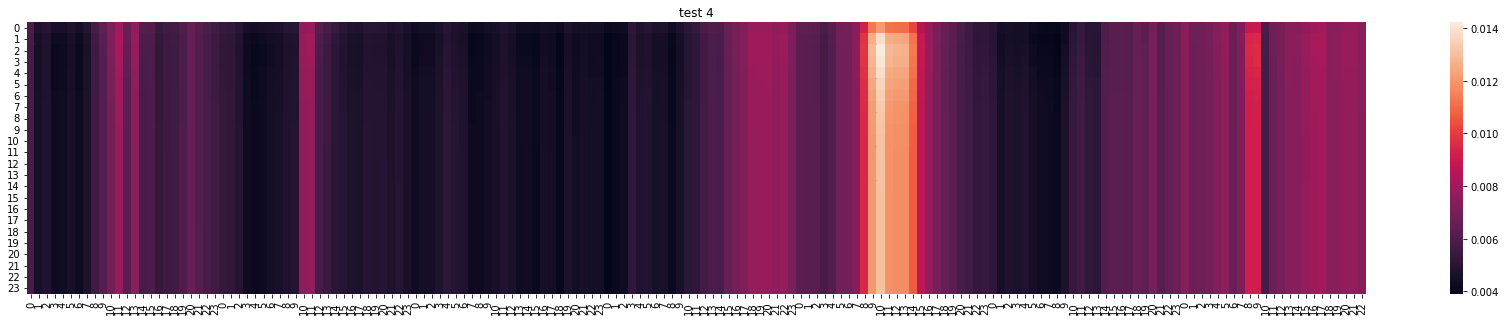

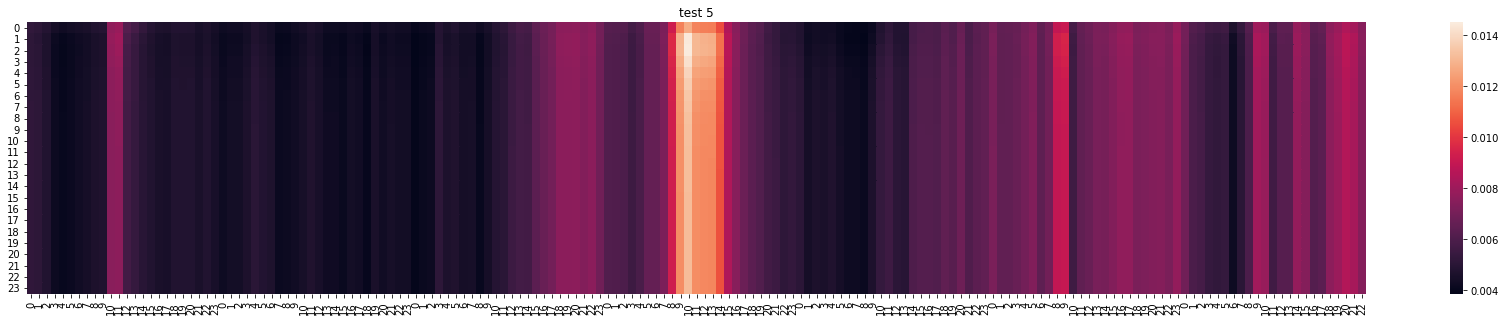

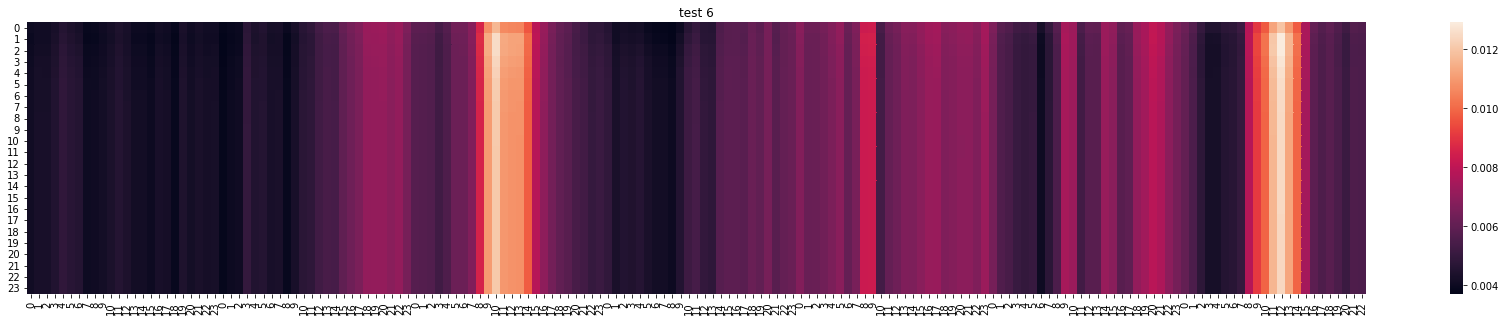

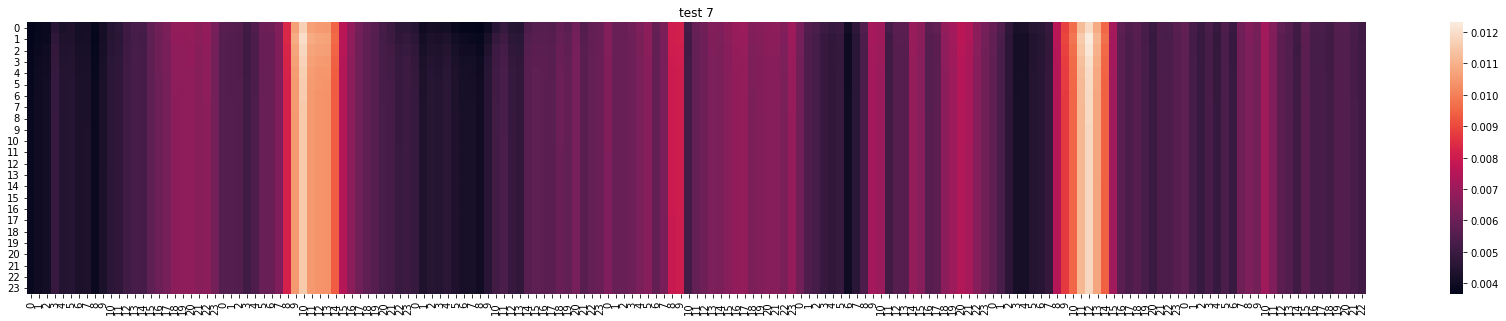

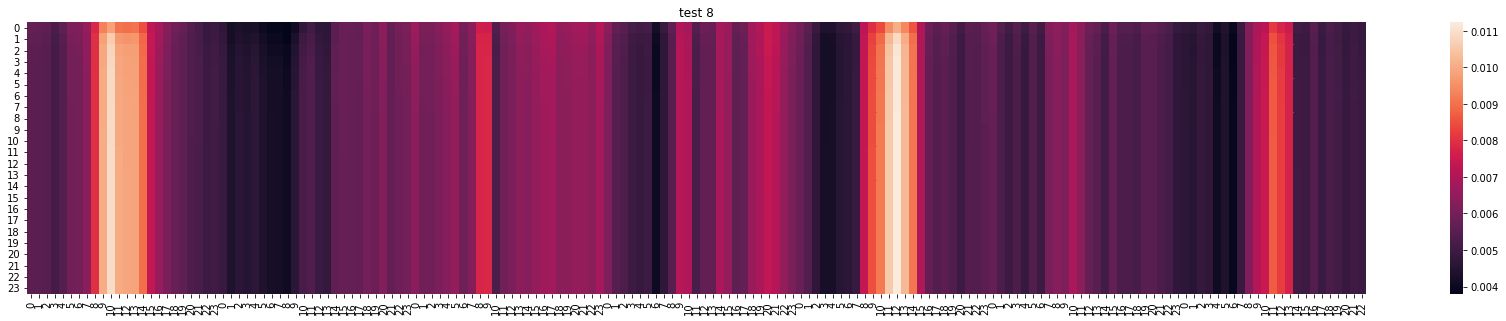

In [ ]:
for i, attention in enumerate(attention_test):
    plt.figure(figsize=(30,5))
    sns.heatmap(attention, xticklabels=[i%24 for i in range(167)])
    plt.title(f"test {i}")
    plt.show()